In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
%load_ext autoreload
%autoreload 2
import sys

path = "C:/Users/schiavaz/lava-nc/depth/"
sys.path.append(path)

import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import open3d as o3d
from tqdm import tqdm

import events_utils.filter as flt
import events_utils.visualize as vis
import events_utils.time_difference as td
import events_utils.time_difference_2d as td2d
import events_utils.tum_vie as tum_dset
import events_utils.flow as flow_utils

from scipy.spatial.transform import Rotation as R

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [596]:
#define time range
t_start = 2.5
duration = 0.05
t_end = t_start + duration
shape = (180, 240)
dataset = "data/esim_data/curvy/"

In [597]:
events_raw = np.loadtxt(path + dataset + "events.txt", max_rows=10000000)

In [598]:
sub_factor=1

In [599]:
patch_center = (90, 90)
patch_size = 180

In [600]:
shape = (patch_size, patch_size)
events_p = flt.filter_patch(events_raw, patch_center, patch_size)

In [601]:
events_conv, new_shape = flt.filter_conv(events_p, shape, factor=sub_factor)
shape = new_shape
print(shape)

(180, 180)


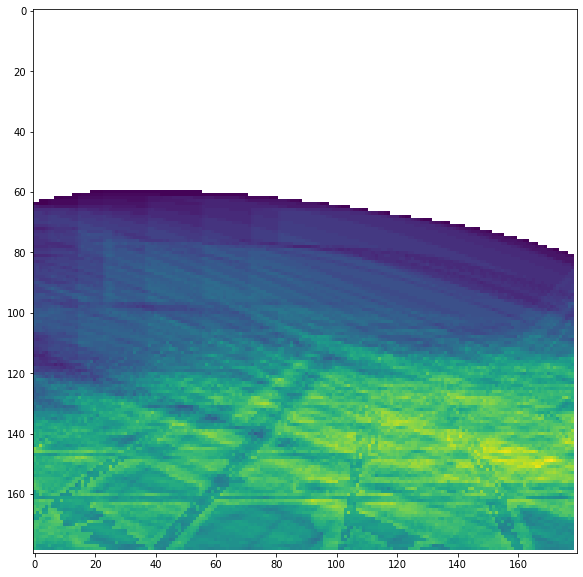

In [602]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2img(events_conv, shape, filter_polarity=False, polarity=1)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

In [603]:
events = flt.filter_refract(events_conv, 0.2)

In [604]:
events = flt.filter_time(events, t_start, t_end)

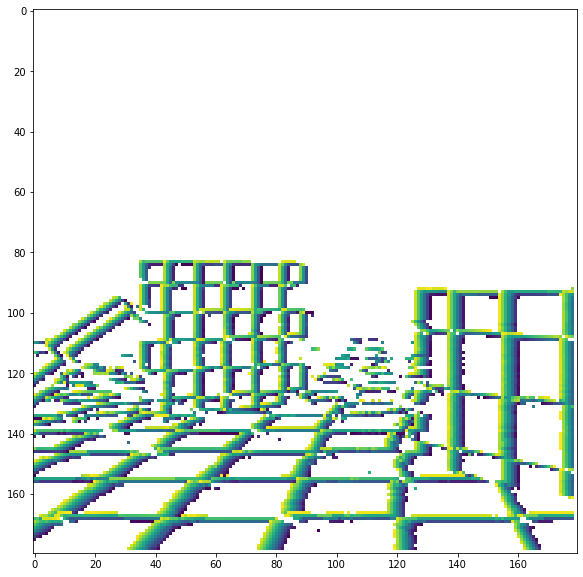

In [605]:
%matplotlib inline
plt.figure(figsize=(10, 10))
img = vis.events2time_surf(events, shape, filter_polarity=False, polarity=0)
img_m = np.ma.masked_where(img == 0, img)
m = plt.imshow(img_m, interpolation="none")
#plt.colorbar(mappable=m)

In [606]:
calib = np.loadtxt(path + dataset + "calib.txt") / sub_factor
calib[0] = 200
calib[1] = 200
calib[2] = 120
calib[3] = 90

In [607]:
poses = np.loadtxt(path + dataset + "groundtruth.txt")
poses[:, [1, 2, 3]] = poses[:, [2, 3, 1]]

In [608]:
# k = np.ones(100)
# poses[:,1] = np.convolve(poses[:,1], k, mode="same")
# poses[:,2] = np.convolve(poses[:,2], k, mode="same")
# poses[:,3] = np.convolve(poses[:,3], k, mode="same")
# poses[:,4] = np.convolve(poses[:,4], k, mode="same")
# poses[:,5] = np.convolve(poses[:,5], k, mode="same")
# poses[:,6] = np.convolve(poses[:,6], k, mode="same")
# poses[:,7] = np.convolve(poses[:,7], k, mode="same")

# plt.plot(poses[:,0], poses[:,1], label="x")
# plt.plot(poses[:,0], poses[:,2], label="y")
# plt.plot(poses[:,0], poses[:,3], label="z")
# # plt.plot(poses[:,0], poses[:,4], label="q1")
# # plt.plot(poses[:,0], poses[:,5], label="q2")
# # plt.plot(poses[:,0], poses[:,6], label="q3")
# # plt.plot(poses[:,0], poses[:,7], label="q4")
# plt.legend()

In [609]:
# U, V, std_u, std_v = td2d.measure_td2(events, shape, dist=1, px_range_pred=5, std_thr=1.1, mean_thr=10.01, start_delay=0.00, final_delay=0.00)

In [610]:
U, V = td2d.measure_td_raw(events, shape, dist=1)

100%|██████████████████████████████████████████████████████████████████████████| 7152/7152 [00:00<00:00, 130995.87it/s]


In [611]:
# std_u_m = np.ma.masked_where(std_u == 0.0, std_u)
# plt.hist(std_u_m.compressed(), 100, range=(0, 0.01));

In [612]:
m = np.sqrt(U**2 + V**2)

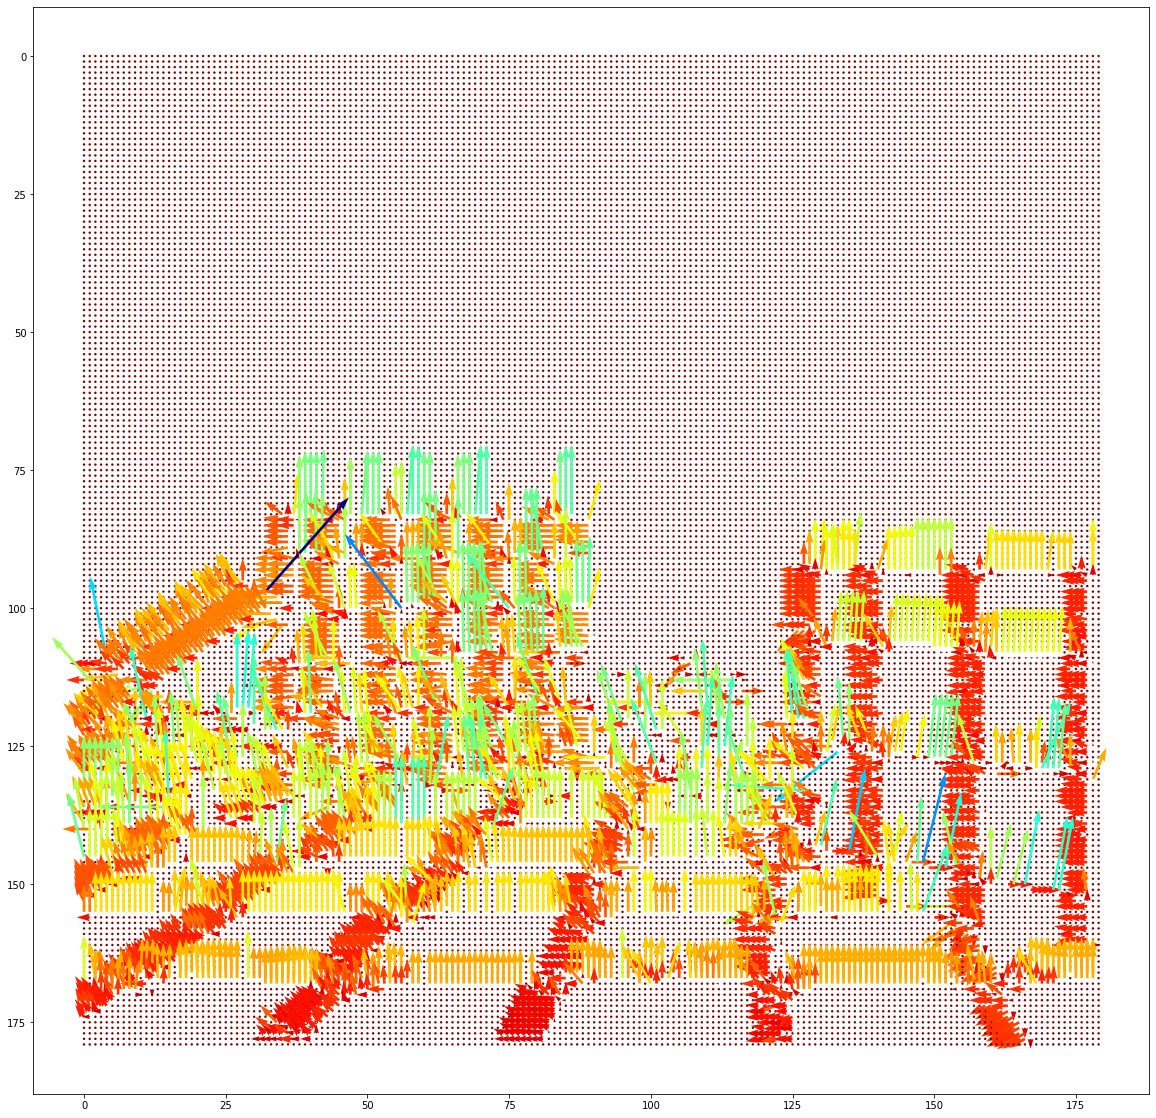

In [613]:
%matplotlib inline
plt.figure(figsize=(20, 20))
plt.quiver(U, V, m, cmap="jet_r")
plt.gca().invert_yaxis()

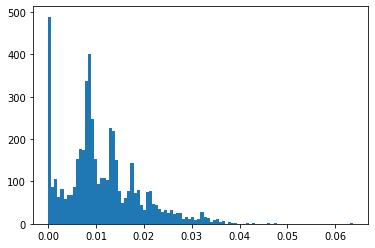

In [614]:
m_ma = np.ma.masked_where(np.isclose(m, 0.0), m)
plt.hist(m_ma.compressed(), 100);

In [615]:
C = [calib[2], calib[3]]

In [616]:
idx = np.searchsorted(poses[:, 0], t_start)
pose1 = poses[idx]
pose2 = poses[idx + 1]

ang1 = R.from_quat(pose1[4:]).as_euler("xyz")
ang2 = R.from_quat(pose2[4:]).as_euler("xyz")

vel = (ang2 - ang1) / (pose2[0] - pose1[0])

print(vel)

[0. 0. 0.]


In [617]:
ang_U, ang_V = flow_utils.get_angular_flow(vel, calib[0], C, shape)

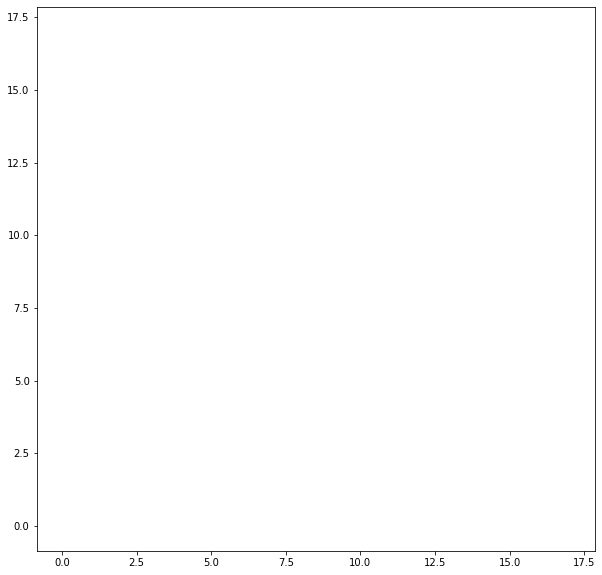

In [618]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(ang_U[::10, ::10], ang_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [619]:
idx = np.searchsorted(poses[:, 0], t_start)
pose1 = poses[idx]
pose2 = poses[idx + 10]

t1 = pose1[1:4]
t2 = pose2[1:4]

print(pose1)
print(pose2)

t_vel = (t2 - t1) / (pose2[0] - pose1[0])
print(t_vel)

print(pose2[0] - pose1[0])

[ 2.50007861  0.47641753 -1.46455124  2.36971211  0.49999999  0.50000005
 -0.49999999 -0.49999996]
[ 2.508       0.48377565 -1.46758504  2.36971211  0.49999999  0.50000005
 -0.49999999 -0.49999996]
[ 0.92889205 -0.38298905  0.        ]
0.007921387000000113


In [620]:
t_U, t_V = flow_utils.get_translational_flow(t_vel, calib[0], C, shape)

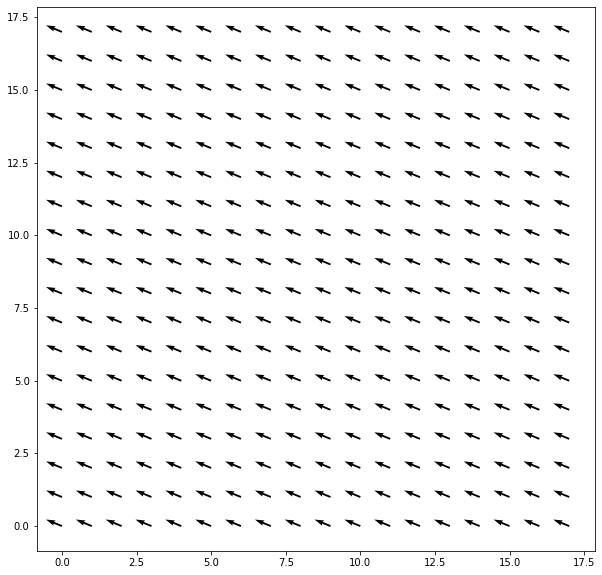

In [621]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(t_U[::10, ::10], t_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [622]:
flow_U = t_U + ang_U
flow_V = t_V + ang_V

In [686]:
t_U

array([[-185.77841, -185.77841, -185.77841, ..., -185.77841, -185.77841,
        -185.77841],
       [-185.77841, -185.77841, -185.77841, ..., -185.77841, -185.77841,
        -185.77841],
       [-185.77841, -185.77841, -185.77841, ..., -185.77841, -185.77841,
        -185.77841],
       ...,
       [-185.77841, -185.77841, -185.77841, ..., -185.77841, -185.77841,
        -185.77841],
       [-185.77841, -185.77841, -185.77841, ..., -185.77841, -185.77841,
        -185.77841],
       [-185.77841, -185.77841, -185.77841, ..., -185.77841, -185.77841,
        -185.77841]])

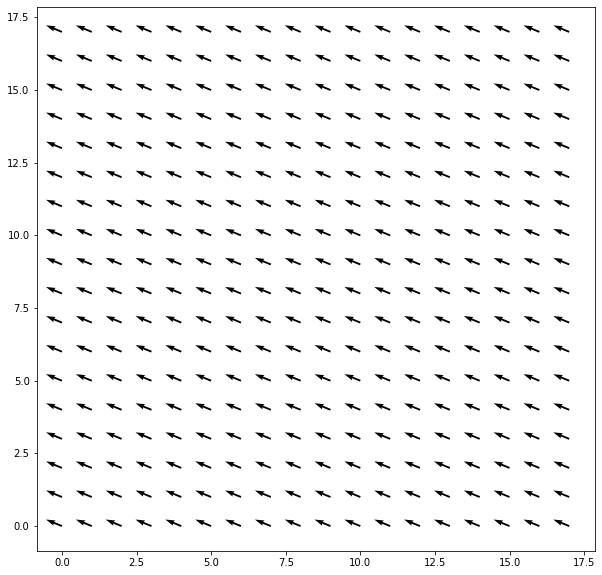

In [624]:
%matplotlib inline
plt.figure(figsize=(10, 10))
plt.quiver(flow_U[::10, ::10], flow_V[::10, ::10], cmap="jet_r")
# plt.gca().invert_yaxis()

In [625]:
test, test_u, test_v = td2d.extract_depth2(shape, U, V, t_U, t_V)

1.5795229774008999


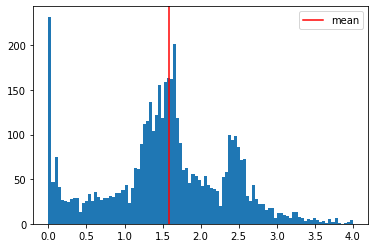

In [626]:
test_m = np.ma.masked_where(np.isclose(test, 0.0), test)
plt.hist(test_m.compressed(), 100, range=(0, 4));
plt.axvline(x=np.ma.mean(test_m), c="red", label="mean")
print(np.ma.mean(test_m))
plt.legend()

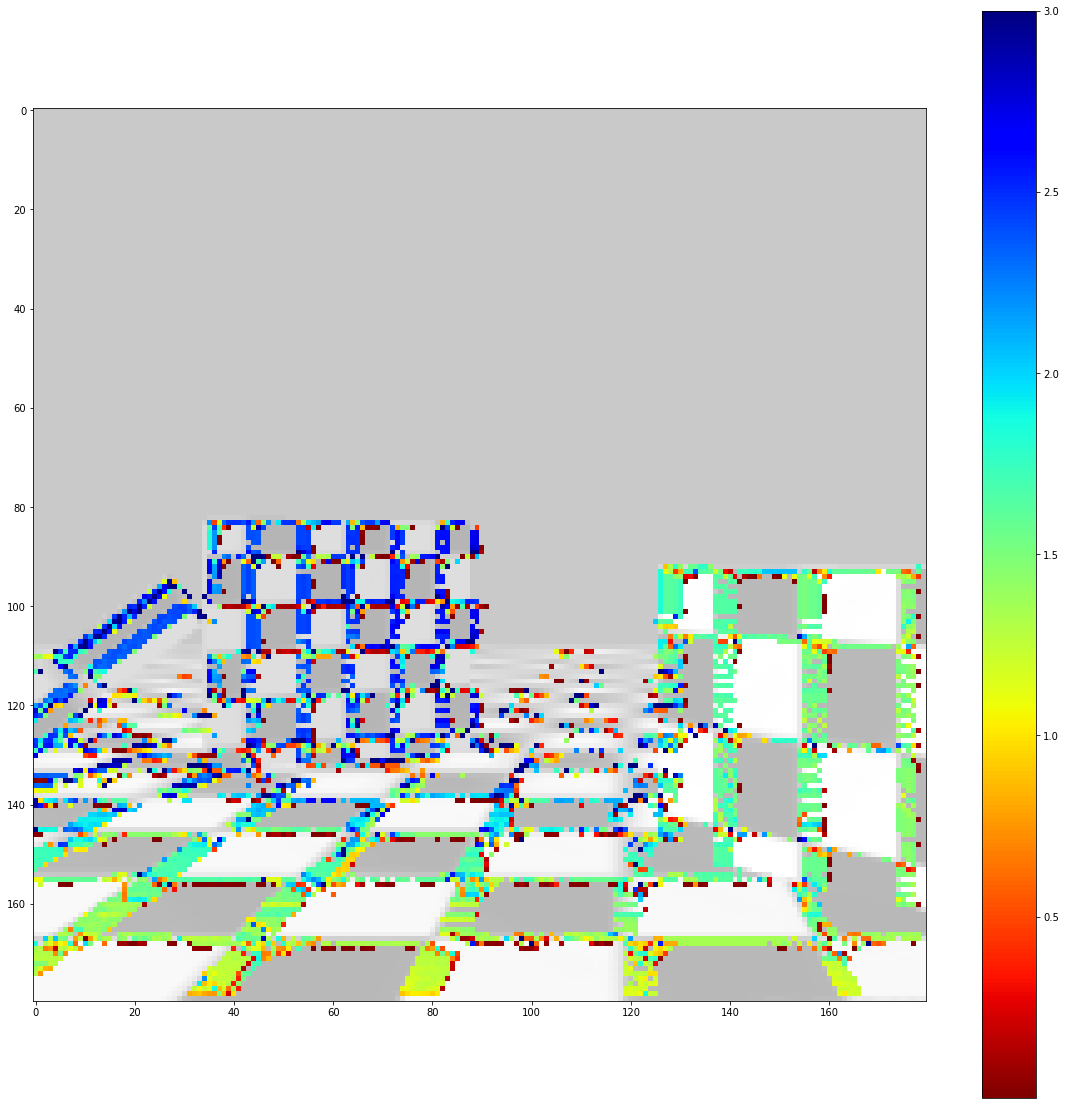

In [656]:
plt.figure(figsize=(20, 20))
img_gray = plt.imread(path + dataset + "images/frame_00000072.png")
plt.imshow(img_gray[::1, ::1], alpha=0.3, cmap="gray")
m = plt.imshow(test_m, interpolation="none", cmap="jet_r", vmax=3)
plt.colorbar(m)

In [657]:
n = 15
test_f = td2d.filter_depth(test_m, 0.7, 9)
# for i in range(1):
#     test_f = td2d.filter_depth(test_f, 2.0, n)
# test_f = td2d.median_filter(test_m, 9)

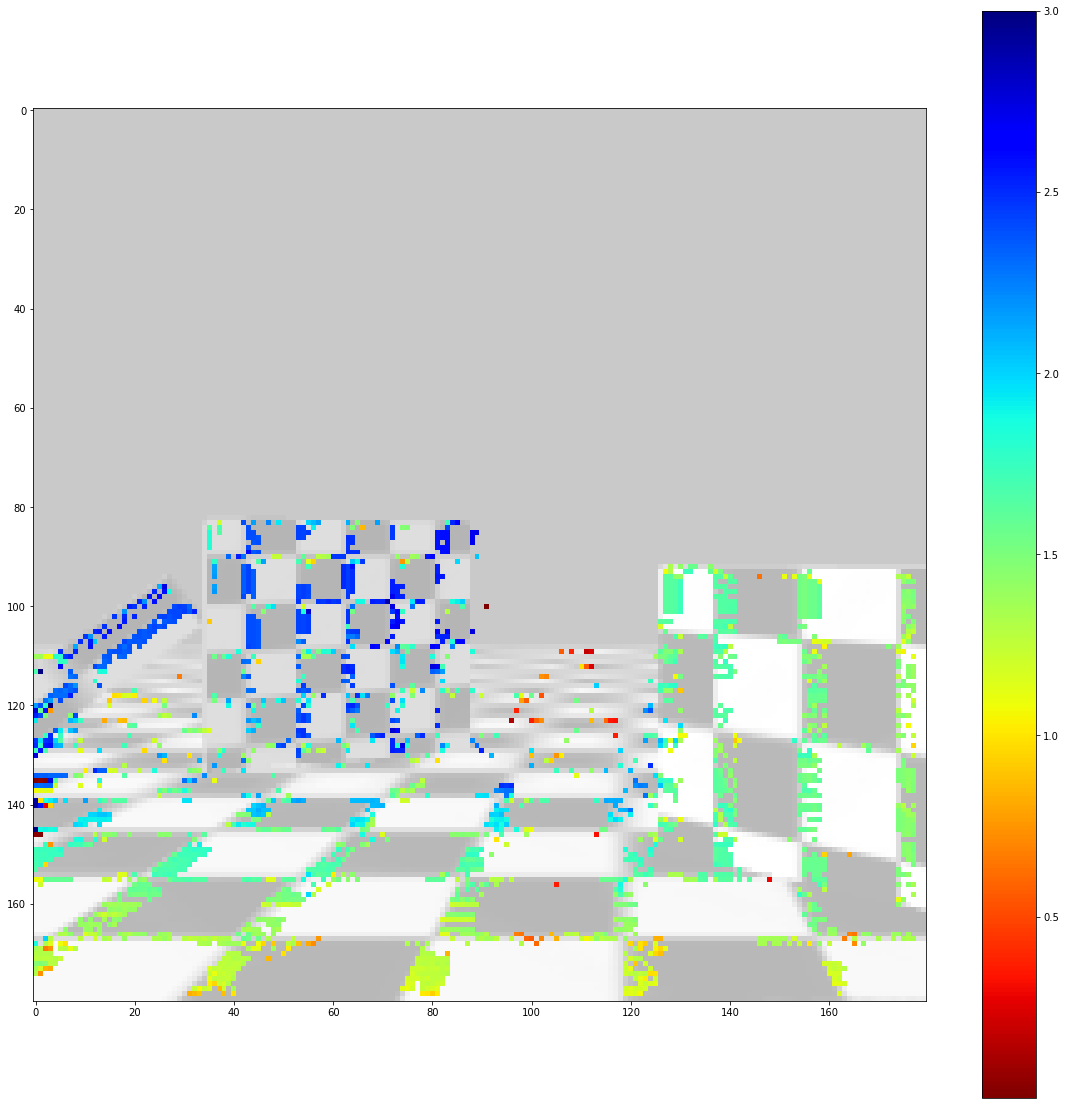

In [659]:
plt.figure(figsize=(20, 20))
img_gray = plt.imread(path + dataset + "images/frame_00000072.png")
plt.imshow(img_gray[::1, ::1], alpha=0.3, cmap="gray")
m = plt.imshow(test_f, interpolation="none", cmap="jet_r", vmax=3)
plt.colorbar(m)

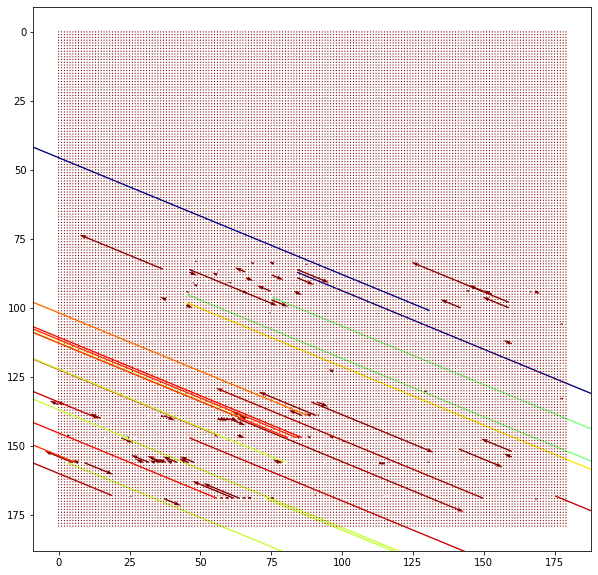

In [660]:
%matplotlib inline
plt.figure(figsize=(10, 10))
a = 1
m = np.sqrt(np.square(test_u[::a, ::a]) + np.square(test_v[::a, ::a]))
plt.quiver(test_u[::a, ::a], test_v[::a, ::a], m[::1, ::1], cmap="jet_r")
plt.gca().invert_yaxis()

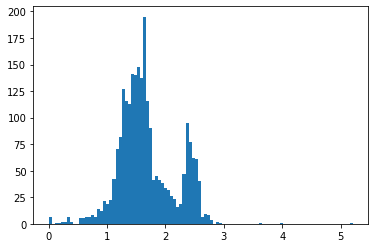

In [661]:
plt.hist(test_f.compressed(), 100);

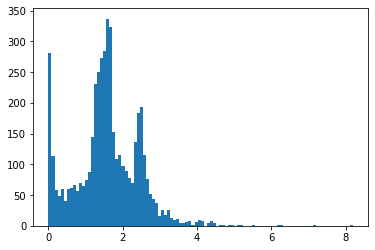

In [662]:
test_m = np.ma.masked_where(test == 0.0, test)
plt.hist(test_m.compressed(), 100);

In [663]:
%matplotlib qt
vis.visualize3d(test_f, s=30, range=(0, 3))

In [664]:
d = test_f

In [665]:
points = vis._image2pointcloud(d)

gt = np.loadtxt(path + dataset + "groundtruth.txt")
idx = np.searchsorted(gt[:, 0], t_start)
p = gt[idx]
#p[[1, 2]] = p[[2, 1]]
print(p)

proj = td.project3d(points, calib, p)

[ 2.50007861  2.36971211  0.47641753 -1.46455124  0.49999999  0.50000005
 -0.49999999 -0.49999996]


In [666]:
proj = proj[proj[:,1] > -5]
pcd = vis.points_to_open3d_pointcloud(proj[:,:3], cmap="jet", z=1)

o3d.visualization.draw_geometries([pcd])

-4.396570499064789
-1.46461165637128
---


In [667]:
%matplotlib qt
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(projection='3d')
ax.scatter(proj[:, 0], proj[:, 2], proj[:, 1], s=2, c=proj[:, 1], cmap="jet")
# ax.set_zlim3d([0.5, 2.5])
vis._set_axes_equal(ax)
plt.show()

In [687]:
gt_depths = np.load(path + dataset + "/depths.npy")

In [688]:
%matplotlib inline
image_index = 72

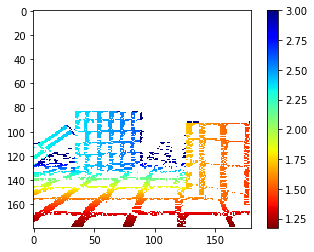

In [692]:
gt_d = gt_depths[image_index,::,:180:]
gt_m = np.ma.masked_where(test_m == 0.0, gt_d)

m = plt.imshow(gt_m, cmap="jet_r", vmax=3, interpolation="none")
plt.colorbar(m)

In [693]:
def measure_error(measured, gt):
    diff = np.abs(measured - gt)
    fig, axs = plt.subplots(2, figsize=(10, 10))
    axs[0].hist(diff.compressed(), 100, range=(0, 5));
    axs[0].axvline(x=np.ma.median(diff), c="red", label="mean")

    m = axs[1].imshow(diff, interpolation="none")
    plt.colorbar(m)

    median = np.ma.median(diff)
    mean = np.ma.mean(diff)
    
    print("median error: {}, mean error: {}".format(median, mean))

median error: 0.2312933156018675, mean error: 1.056981476564021


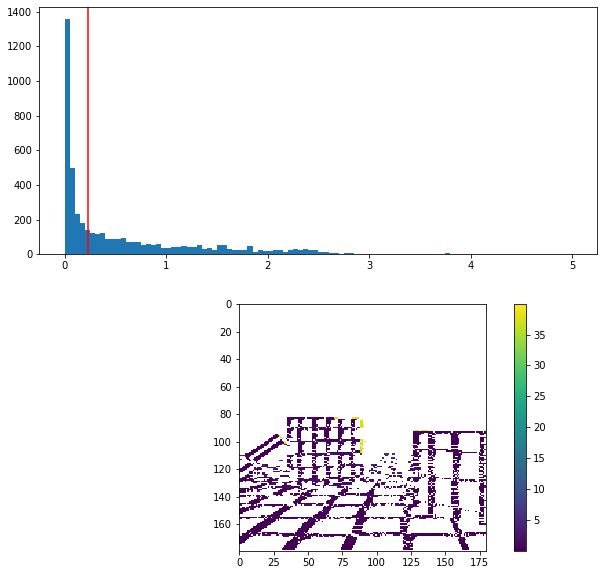

In [695]:
measure_error(test_m, gt_m)

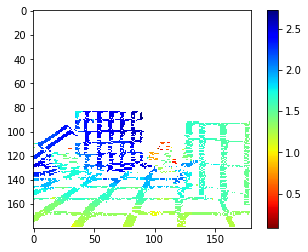

In [697]:
data_median = td2d.median_filter(test_m, 7)

m = plt.imshow(data_median, interpolation="none", cmap="jet_r")
plt.colorbar(m)

median error: 0.04665233956238524, mean error: 0.6614182504180224


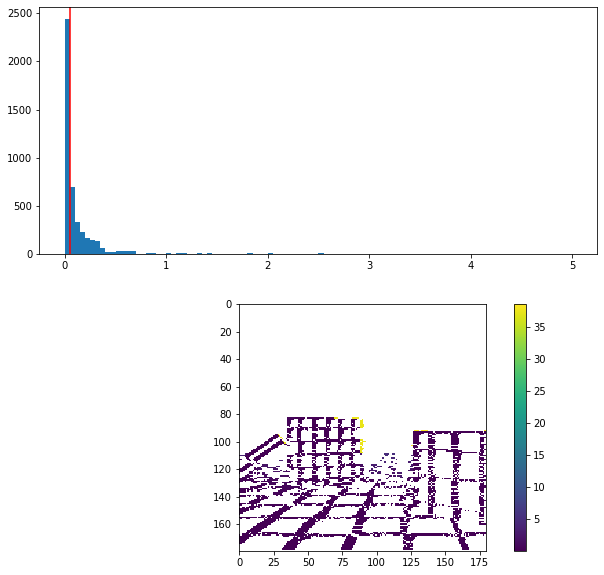

In [698]:
measure_error(data_median, gt_m)

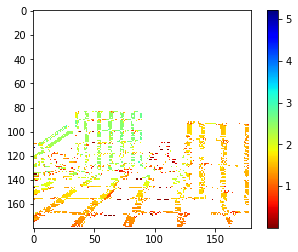

In [703]:
data_mean = td2d.filter_depth(test_m, 1.0, 7)

m = plt.imshow(data_mean, interpolation="none", cmap="jet_r")
plt.colorbar(m)

median error: 0.0850775057215638, mean error: 0.7628278866613026


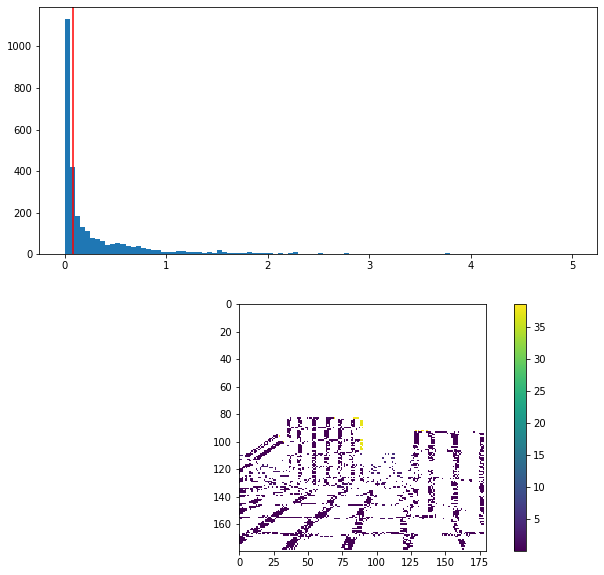

In [704]:
measure_error(data_mean, gt_m)